In [1]:
import sys, os

sys.path.append(os.path.join("..", "src"))

from sindy_core import SINDyModel, SINDyConfig
from derivatives import (  # 👈 new
    finite_difference_derivative,
    sgolay_derivative,
    tv_derivative,
)
from systems import LorenzDefinition
from plotting import (
    plot_time_series,
    plot_phase,
    plot_3d,
    plot_time_series_comparison,
    plot_3d_comparison,
    plot_error_time_series,
)
import jax.numpy as jnp
import jax.random as jr
import numpy as np
import matplotlib.pyplot as plt

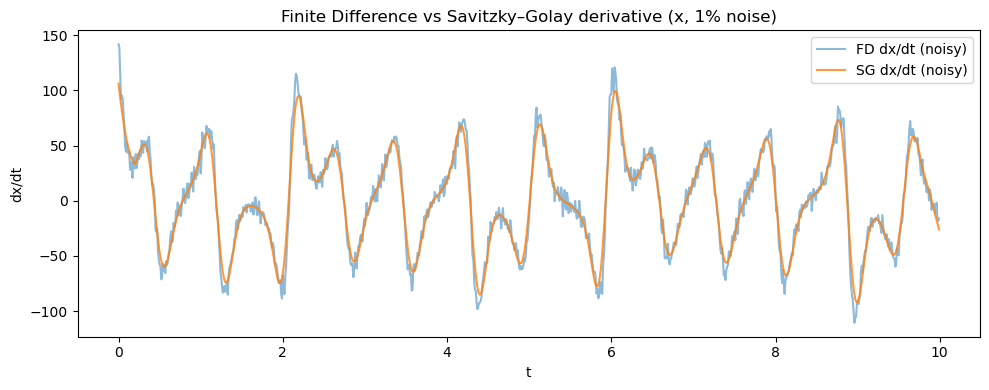

FD RMSE (dx/dt): 5.258926667163442
SG RMSE (dx/dt): 7.045701074220666


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.signal import savgol_filter

# -----------------------------
# 1. Lorenz system + simulation
# -----------------------------


def lorenz_rhs(t, x, sigma=10.0, rho=28.0, beta=8 / 3):
    dx = sigma * (x[1] - x[0])
    dy = x[0] * (rho - x[2]) - x[1]
    dz = x[0] * x[1] - beta * x[2]
    return np.array([dx, dy, dz])


t0, tf, dt = 0.0, 10.0, 0.01
t_eval = np.arange(t0, tf, dt)
x0 = np.array([-8.0, 7.0, 27.0])

sol = solve_ivp(lorenz_rhs, (t0, tf), x0, t_eval=t_eval, rtol=1e-10, atol=1e-12)
ts = sol.t  # (N,)
xs_clean = sol.y.T  # (N, 3)

# -----------------------------
# 2. Add 1% relative Gaussian noise
# -----------------------------


def add_relative_noise(X, pct, rng=None, eps=1e-12):
    rng = np.random.default_rng() if rng is None else rng
    X = np.asarray(X)
    std = np.maximum(X.std(axis=0, ddof=1), eps)
    sigma = pct * std
    noise = rng.normal(0.0, sigma, size=X.shape)
    return X + noise


rng = np.random.default_rng(0)
xs_noisy = add_relative_noise(xs_clean, pct=0.01, rng=rng)

# -----------------------------
# 3. Derivative estimators
# -----------------------------


def finite_difference_derivative(ts, X):
    ts = np.asarray(ts)
    X = np.asarray(X)
    dt = np.diff(ts)
    if not np.allclose(dt, dt[0]):
        raise ValueError("finite_difference_derivative assumes uniform dt.")
    dt = dt[0]

    Xdot = np.zeros_like(X)
    Xdot[1:-1] = (X[2:] - X[:-2]) / (2 * dt)
    Xdot[0] = (X[1] - X[0]) / dt
    Xdot[-1] = (X[-1] - X[-2]) / dt
    return Xdot


def sgolay_derivative(ts, X, window_length=151, polyorder=3):
    ts = np.asarray(ts)
    X = np.asarray(X)
    dt = np.diff(ts)
    if not np.allclose(dt, dt[0]):
        raise ValueError("sgolay_derivative assumes uniform dt.")
    dt = dt[0]

    if window_length % 2 == 0:
        raise ValueError("window_length must be odd.")

    Xdot = np.zeros_like(X)
    for j in range(X.shape[1]):
        x_np = np.asarray(X[:, j])
        Xdot[:, j] = savgol_filter(
            x_np,
            window_length=window_length,
            polyorder=polyorder,
            deriv=1,
            delta=dt,
            mode="interp",
        )
    return Xdot


Xdot_fd = finite_difference_derivative(ts, xs_noisy)
Xdot_sg = sgolay_derivative(ts, xs_noisy, window_length=41, polyorder=3)

# -----------------------------
# 4. Plot: FD vs SG derivative (x component)
# -----------------------------

i = 0  # x state

plt.figure(figsize=(10, 4))
plt.plot(ts, Xdot_fd[:, i], label="FD dx/dt (noisy)", alpha=0.5)
plt.plot(ts, Xdot_sg[:, i], label="SG dx/dt (noisy)", alpha=0.8)
plt.xlabel("t")
plt.ylabel("dx/dt")
plt.title("Finite Difference vs Savitzky–Golay derivative (x, 1% noise)")
plt.legend()
plt.tight_layout()
plt.show()


# true derivative from the Lorenz RHS
def lorenz_rhs_vec(ts, xs):
    return np.vstack([lorenz_rhs(t, x) for t, x in zip(ts, xs)])


Xdot_true = lorenz_rhs_vec(ts, xs_clean)


def rmse(a, b):
    return np.sqrt(np.mean((a - b) ** 2))


i = 0  # x component
print("FD RMSE (dx/dt):", rmse(Xdot_fd[:, i], Xdot_true[:, i]))
print("SG RMSE (dx/dt):", rmse(Xdot_sg[:, i], Xdot_true[:, i]))

In [3]:
candidates = [5, 7, 9, 11, 15, 21, 31, 41, 51]

print("FD RMSE (dx/dt):", rmse(Xdot_fd[:, 0], Xdot_true[:, 0]))

for wl in candidates:
    if wl <= 3 or wl % 2 == 0:
        continue  # need odd and > polyorder=3
    Xdot_sg = sgolay_derivative(ts, xs_noisy, window_length=wl, polyorder=3)
    sg_rmse = rmse(Xdot_sg[:, 0], Xdot_true[:, 0])
    print(f"window_length={wl:2d} -> SG RMSE (dx/dt): {sg_rmse:.4f}")

FD RMSE (dx/dt): 5.258926667163442
window_length= 5 -> SG RMSE (dx/dt): 6.9935
window_length= 7 -> SG RMSE (dx/dt): 3.9629
window_length= 9 -> SG RMSE (dx/dt): 2.6465
window_length=11 -> SG RMSE (dx/dt): 1.9474
window_length=15 -> SG RMSE (dx/dt): 1.1651
window_length=21 -> SG RMSE (dx/dt): 1.1408
window_length=31 -> SG RMSE (dx/dt): 3.2769
window_length=41 -> SG RMSE (dx/dt): 7.0457
window_length=51 -> SG RMSE (dx/dt): 12.3833


# Switch to window_length =21

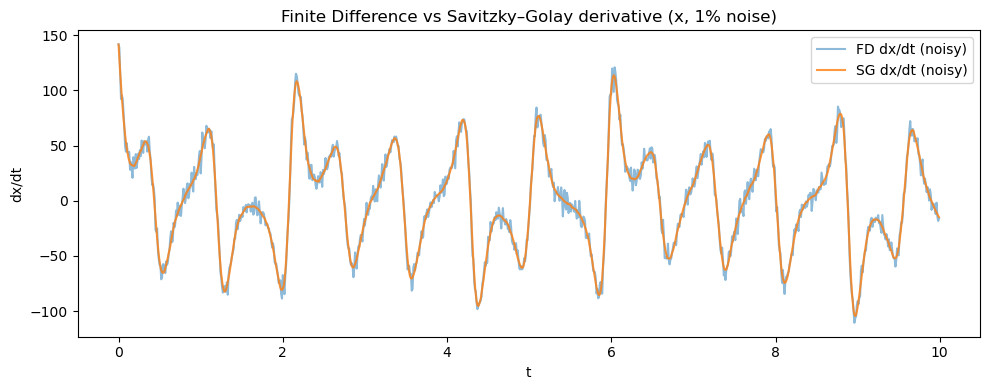

FD RMSE (dx/dt): 5.258926667163442
SG RMSE (dx/dt): 1.1408165588521706


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.signal import savgol_filter

# -----------------------------
# 1. Lorenz system + simulation
# -----------------------------


def lorenz_rhs(t, x, sigma=10.0, rho=28.0, beta=8 / 3):
    dx = sigma * (x[1] - x[0])
    dy = x[0] * (rho - x[2]) - x[1]
    dz = x[0] * x[1] - beta * x[2]
    return np.array([dx, dy, dz])


t0, tf, dt = 0.0, 10.0, 0.01
t_eval = np.arange(t0, tf, dt)
x0 = np.array([-8.0, 7.0, 27.0])

sol = solve_ivp(lorenz_rhs, (t0, tf), x0, t_eval=t_eval, rtol=1e-10, atol=1e-12)
ts = sol.t  # (N,)
xs_clean = sol.y.T  # (N, 3)

# -----------------------------
# 2. Add 1% relative Gaussian noise
# -----------------------------


def add_relative_noise(X, pct, rng=None, eps=1e-12):
    rng = np.random.default_rng() if rng is None else rng
    X = np.asarray(X)
    std = np.maximum(X.std(axis=0, ddof=1), eps)
    sigma = pct * std
    noise = rng.normal(0.0, sigma, size=X.shape)
    return X + noise


rng = np.random.default_rng(0)
xs_noisy = add_relative_noise(xs_clean, pct=0.01, rng=rng)

# -----------------------------
# 3. Derivative estimators
# -----------------------------


def finite_difference_derivative(ts, X):
    ts = np.asarray(ts)
    X = np.asarray(X)
    dt = np.diff(ts)
    if not np.allclose(dt, dt[0]):
        raise ValueError("finite_difference_derivative assumes uniform dt.")
    dt = dt[0]

    Xdot = np.zeros_like(X)
    Xdot[1:-1] = (X[2:] - X[:-2]) / (2 * dt)
    Xdot[0] = (X[1] - X[0]) / dt
    Xdot[-1] = (X[-1] - X[-2]) / dt
    return Xdot


def sgolay_derivative(ts, X, window_length=21, polyorder=3):
    ts = np.asarray(ts)
    X = np.asarray(X)
    dt = np.diff(ts)
    if not np.allclose(dt, dt[0]):
        raise ValueError("sgolay_derivative assumes uniform dt.")
    dt = dt[0]

    if window_length % 2 == 0:
        raise ValueError("window_length must be odd.")

    Xdot = np.zeros_like(X)
    for j in range(X.shape[1]):
        x_np = np.asarray(X[:, j])
        Xdot[:, j] = savgol_filter(
            x_np,
            window_length=window_length,
            polyorder=polyorder,
            deriv=1,
            delta=dt,
            mode="interp",
        )
    return Xdot


Xdot_fd = finite_difference_derivative(ts, xs_noisy)
Xdot_sg = sgolay_derivative(ts, xs_noisy, window_length=21, polyorder=3)

# -----------------------------
# 4. Plot: FD vs SG derivative (x component)
# -----------------------------

i = 0  # x state

plt.figure(figsize=(10, 4))
plt.plot(ts, Xdot_fd[:, i], label="FD dx/dt (noisy)", alpha=0.5)
plt.plot(ts, Xdot_sg[:, i], label="SG dx/dt (noisy)", alpha=0.8)
plt.xlabel("t")
plt.ylabel("dx/dt")
plt.title("Finite Difference vs Savitzky–Golay derivative (x, 1% noise)")
plt.legend()
plt.tight_layout()
plt.show()


# true derivative from the Lorenz RHS
def lorenz_rhs_vec(ts, xs):
    return np.vstack([lorenz_rhs(t, x) for t, x in zip(ts, xs)])


Xdot_true = lorenz_rhs_vec(ts, xs_clean)


def rmse(a, b):
    return np.sqrt(np.mean((a - b) ** 2))


i = 0  # x component
print("FD RMSE (dx/dt):", rmse(Xdot_fd[:, i], Xdot_true[:, i]))
print("SG RMSE (dx/dt):", rmse(Xdot_sg[:, i], Xdot_true[:, i]))

In [5]:
import sys, os

sys.path.append(os.path.join("..", "src"))

from sindy_core import SINDyModel, SINDyConfig
from derivatives import (  # 👈 new
    finite_difference_derivative,
    sgolay_derivative,
    tv_derivative,
)
from systems import LorenzDefinition
from plotting import (
    plot_time_series,
    plot_phase,
    plot_3d,
    plot_time_series_comparison,
    plot_3d_comparison,
    plot_error_time_series,
)
import jax.numpy as jnp
import jax.random as jr
import numpy as np
import matplotlib.pyplot as plt

In [6]:
# --- TV derivative on the same noisy data ---
Xdot_tv = tv_derivative(
    ts,
    xs_noisy,
    alpha=1e-4,  # start with your default
    n_iters=15,
)

Xdot_tv_np = np.asarray(Xdot_tv)

for i, name in enumerate(["x", "y", "z"]):
    fd_err = rmse(Xdot_fd[:, i], Xdot_true[:, i])
    sg_err = rmse(Xdot_sg[:, i], Xdot_true[:, i])
    tv_err = rmse(Xdot_tv_np[:, i], Xdot_true[:, i])
    print(f"{name}: FD={fd_err:.3f}, SG={sg_err:.3f}, TV={tv_err:.3f}")

x: FD=5.259, SG=1.141, TV=4.754
y: FD=6.044, SG=3.013, TV=6.648
z: FD=6.285, SG=2.992, TV=7.507


In [7]:
alphas = [1e-6, 5e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3]

for a in alphas:
    Xdot_tv = tv_derivative(ts, xs_noisy, alpha=a, n_iters=20)
    Xdot_tv_np = np.asarray(Xdot_tv)
    errs = [rmse(Xdot_tv_np[:, i], Xdot_true[:, i]) for i in range(3)]
    print(f"alpha={a:.0e}  ->  RMSE(x,y,z) = {errs}")

alpha=1e-06  ->  RMSE(x,y,z) = [np.float64(8.758777272470958), np.float64(10.025616128561222), np.float64(11.252634019671234)]
alpha=5e-06  ->  RMSE(x,y,z) = [np.float64(6.342117076125408), np.float64(7.261100605722801), np.float64(8.681350257726983)]
alpha=1e-05  ->  RMSE(x,y,z) = [np.float64(5.898074287228385), np.float64(6.8934270149782595), np.float64(8.268667540720957)]
alpha=5e-05  ->  RMSE(x,y,z) = [np.float64(4.923188767997409), np.float64(6.51677991291428), np.float64(7.5327190133306585)]
alpha=1e-04  ->  RMSE(x,y,z) = [np.float64(4.769700591051695), np.float64(6.667459527886366), np.float64(7.547186041115775)]
alpha=5e-04  ->  RMSE(x,y,z) = [np.float64(5.578351434530193), np.float64(8.22799560392386), np.float64(8.841332975092422)]
alpha=1e-03  ->  RMSE(x,y,z) = [np.float64(6.344783557691731), np.float64(9.495018245451796), np.float64(9.750469844102081)]


In [8]:
import jax.numpy as jnp

ts_j = jnp.linspace(0, 10, 10001)
xs_j = jnp.column_stack([
    jnp.sin(ts_j),
    jnp.cos(ts_j),
])

# First call: compiles
%time Xdot1 = finite_difference_derivative(ts_j, xs_j).block_until_ready()

# Second call: reuses compiled version
%time Xdot2 = finite_difference_derivative(ts_j, xs_j).block_until_ready()


CPU times: total: 62.5 ms
Wall time: 45.6 ms
CPU times: total: 0 ns
Wall time: 335 μs


In [10]:
# --- Required setup for the derivative sweep ---

import jax.numpy as jnp
import jax.random as jr
import numpy as np

from systems import LorenzDefinition
from derivatives import (
    finite_difference_derivative,
    sgolay_derivative,
    tv_derivative,
)

# 1) Instantiate Lorenz model
lorenz_params = {"sigma": 10.0, "rho": 28.0, "beta": 8 / 3}
lorenz_x0 = jnp.array([-8.0, 7.0, 27.0])

lorenz = LorenzDefinition(
    parameters=lorenz_params,
    x0_vector=lorenz_x0,
    t0=0.0,
    tf=10.0,
    dt=0.01,
)

# 2) Simulate CLEAN reference trajectory once
ts, xs_clean = lorenz.simulate()

# 3) True derivatives (gold standard)
Xdot_true = np.asarray([lorenz.rhs(t, x) for t, x in zip(ts, xs_clean)])


def rmse(a, b):
    a = np.asarray(a)
    b = np.asarray(b)
    return np.sqrt(np.mean((a - b) ** 2))

In [11]:
# --- Derivative RMSE sweep across noise levels ---

noise_levels = [0.00, 0.01, 0.05, 0.10]

# True derivatives (from clean xs)
ts, xs_clean = lorenz.simulate()
Xdot_true = np.asarray([lorenz.rhs(t, x) for t, x in zip(ts, xs_clean)])


def rmse(a, b):
    return np.sqrt(np.mean((np.asarray(a) - np.asarray(b)) ** 2))


for pct in noise_levels:
    print(f"\n=== Noise Level: {pct*100:.0f}% ===")

    # Use model's built-in noise injection
    key = jr.PRNGKey(0)
    ts_noisy, xs_noisy = lorenz.simulate_with_noise(noise_pct=pct, key=key)

    # Derivatives
    Xdot_fd = finite_difference_derivative(ts_noisy, xs_noisy)
    Xdot_sg = sgolay_derivative(
        ts_noisy, xs_noisy, window_length=21, polyorder=3
    )
    Xdot_tv = tv_derivative(ts_noisy, xs_noisy, alpha=5e-5, n_iters=20)

    for i, name in enumerate(["x", "y", "z"]):
        err_fd = rmse(Xdot_fd[:, i], Xdot_true[:, i])
        err_sg = rmse(Xdot_sg[:, i], Xdot_true[:, i])
        err_tv = rmse(Xdot_tv[:, i], Xdot_true[:, i])

        print(f"{name}:  FD={err_fd:.3f},  SG={err_sg:.3f},  TV={err_tv:.3f}")


=== Noise Level: 0% ===
x:  FD=0.295,  SG=0.941,  TV=4.074
y:  FD=0.369,  SG=2.949,  TV=5.407
z:  FD=0.422,  SG=2.916,  TV=6.213

=== Noise Level: 1% ===
x:  FD=5.433,  SG=1.145,  TV=4.785
y:  FD=6.009,  SG=3.126,  TV=6.392
z:  FD=6.176,  SG=3.083,  TV=7.325

=== Noise Level: 5% ===
x:  FD=27.119,  SG=3.306,  TV=8.821
y:  FD=29.941,  SG=5.132,  TV=11.581
z:  FD=30.712,  SG=5.200,  TV=13.125

=== Noise Level: 10% ===
x:  FD=54.233,  SG=6.384,  TV=22.171
y:  FD=59.865,  SG=8.640,  TV=27.702
z:  FD=61.394,  SG=8.913,  TV=27.699


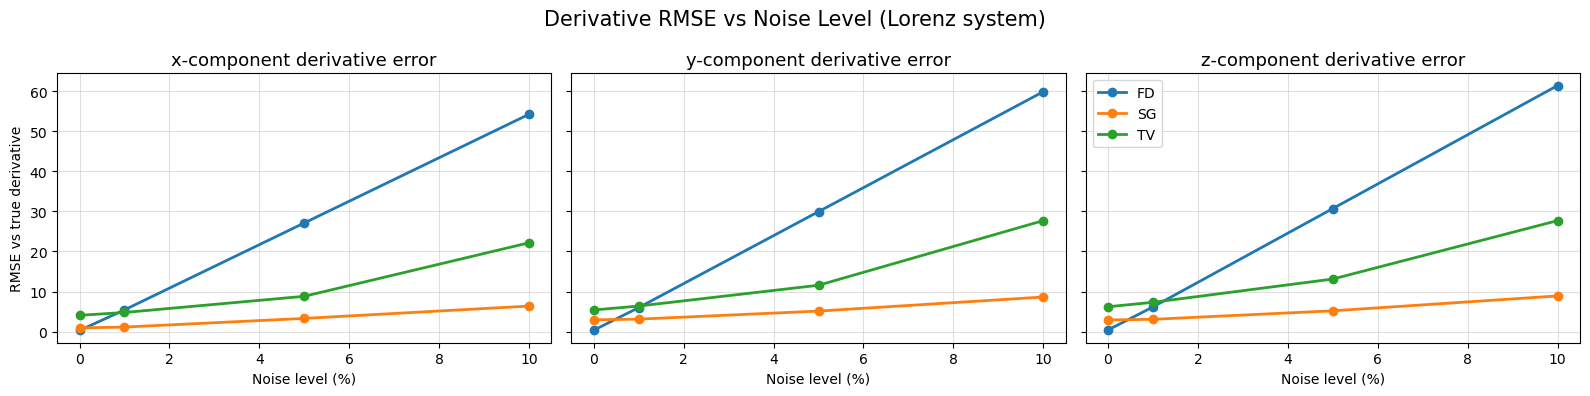

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# --- noise levels used ---
noise_levels = np.array([0.00, 0.01, 0.05, 0.10])

# --- store RMSE results collected earlier ---
# Fill these from your printed output
FD_rmse = {
    "x": np.array([0.295, 5.433, 27.119, 54.233]),
    "y": np.array([0.369, 6.009, 29.941, 59.865]),
    "z": np.array([0.422, 6.176, 30.712, 61.394]),
}

SG_rmse = {
    "x": np.array([0.941, 1.145, 3.306, 6.384]),
    "y": np.array([2.949, 3.126, 5.132, 8.640]),
    "z": np.array([2.916, 3.083, 5.200, 8.913]),
}

TV_rmse = {
    "x": np.array([4.074, 4.785, 8.821, 22.171]),
    "y": np.array([5.407, 6.392, 11.581, 27.702]),
    "z": np.array([6.213, 7.325, 13.125, 27.699]),
}

# --- plot RMSE curves for each state variable ---
fig, axes = plt.subplots(1, 3, figsize=(16, 4), sharey=True)

states = ["x", "y", "z"]

for ax, var in zip(axes, states):
    ax.plot(noise_levels * 100, FD_rmse[var], "o-", label="FD", linewidth=2)
    ax.plot(noise_levels * 100, SG_rmse[var], "o-", label="SG", linewidth=2)
    ax.plot(noise_levels * 100, TV_rmse[var], "o-", label="TV", linewidth=2)

    ax.set_title(f"{var}-component derivative error", fontsize=13)
    ax.set_xlabel("Noise level (%)")
    ax.grid(True, alpha=0.4)

axes[0].set_ylabel("RMSE vs true derivative")
axes[-1].legend()
plt.suptitle("Derivative RMSE vs Noise Level (Lorenz system)", fontsize=15)
plt.tight_layout()
plt.show()